# II) LGSSM - Kalman Filter

### a)	Implement the Kalman filter for a multidimensional linear-Gaussian SSM

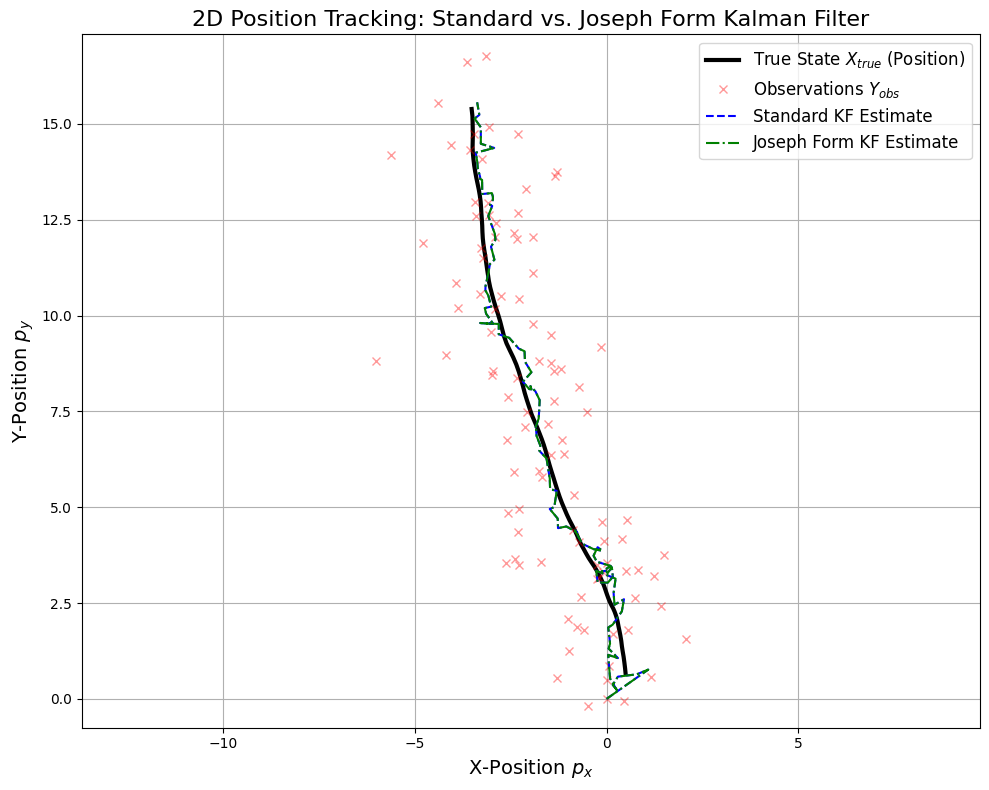

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Set a seed for reproducibility of the synthetic data
np.random.seed(42)

# --- 1. Define Model Parameters (Matrices and Noise Covariances) ---
dt = 0.1  # Time step
nx = 4 # State dimension: [p_x, v_x, p_y, v_y]
ny = 2 # Observation dimension: [p_x, p_y]

# State Transition Matrix A (Constant Velocity Model)
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

# Process Noise Matrix B and Covariance Q
# Assuming process noise affects acceleration
B = np.array([
    [dt**2/2, 0],
    [dt, 0],
    [0, dt**2/2],
    [0, dt]
])
Q = B @ B.T # Process Noise Covariance Q

# Observation Matrix C
# We only observe position [p_x, p_y]
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

# Observation Noise Matrix D and Covariance R
D = np.eye(2)
R = D @ D.T # Observation Noise Covariance R

# Initial Filter State and Covariance (used for both filter runs)
X0_filter = np.array([0.0, 1.0, 0.0, -0.5]) # Filter's initial state estimate
P0_filter = 1.0 * np.eye(4) # Initial Covariance P_{0|0}


# --- 2. Generate Synthetic Data ---
N = 100 # Number of time steps

X_true = np.zeros((N, nx))
Y_obs = np.zeros((N, ny))

# True Initial State (Stochastic initial state for the *system*)
P0_true = 1.0 * np.eye(4)
mean_X0_true = np.zeros(nx)
L_P0_true = np.linalg.cholesky(P0_true)
X_true[0] = mean_X0_true + L_P0_true @ np.random.randn(nx)

# Simulate the process
for n in range(1, N):
    # State Transition: X_n = A * X_{n-1} + process_noise
    # Generate 2D Gaussian noise
    process_noise = (B @ np.random.randn(2))
    X_true[n] = A @ X_true[n-1] + process_noise

    # Observation: Y_n = C * X_n + observation_noise
    # Generate 2D Gaussian noise
    observation_noise = (D @ np.random.randn(2))
    Y_obs[n] = C @ X_true[n] + observation_noise


# --- 3. Kalman Filter Function ---

def run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, update_type):
    N = Y_obs.shape[0]
    nx = A.shape[0]
    I = np.eye(nx)

    X_hat = np.zeros((N, nx)) # X_hat_{n|n}
    P = np.zeros((N, nx, nx)) # P_{n|n}
    X_hat[0] = X0_filter
    P[0] = P0_filter

    cond_numbers = []

    for n in range(1, N):
        # --- Prediction Step (Time Update) ---
        X_hat_prior = A @ X_hat[n-1]
        P_prior = A @ P[n-1] @ A.T + Q

        # --- Update Step (Measurement Update) ---
        S = C @ P_prior @ C.T + R
        K = P_prior @ C.T @ np.linalg.inv(S)

        # Update state estimate
        innovation = Y_obs[n] - C @ X_hat_prior
        X_hat[n] = X_hat_prior + K @ innovation

        # Update covariance (P_{n|n})
        if update_type == 'standard':
            # Standard form: P = (I - K*C) * P_prior
            P[n] = (I - K @ C) @ P_prior
        elif update_type == 'joseph':
            # Joseph form: P = (I - K*C) * P_prior * (I - K*C).T + K * R * K.T
            IC_KC = I - K @ C
            P[n] = IC_KC @ P_prior @ IC_KC.T + K @ R @ K.T
        else:
            raise ValueError("Invalid update_type")

        # Calculate Condition Number for numerical stability check
        cond_number = np.linalg.cond(P[n])
        cond_numbers.append(cond_number)

    return X_hat, P, cond_numbers

# --- 4. Run Comparisons ---

# Run Standard Update
X_hat_std, _, cond_numbers_std = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'standard')

# Run Joseph Update
X_hat_joseph, _, cond_numbers_joseph = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'joseph')

# Extract estimated positions for plotting
P_x_est_std = X_hat_std[:, 0]
P_y_est_std = X_hat_std[:, 2]
P_x_est_joseph = X_hat_joseph[:, 0]
P_y_est_joseph = X_hat_joseph[:, 2]


# --- 5. Plotting Results ---

# Plot 1: Tracking Comparison (Position only)
plt.figure(figsize=(10, 8))

# True State (Position)
plt.plot(X_true[:, 0], X_true[:, 2], 'k-', linewidth=3, label='True State $X_{true}$ (Position)')

# Noisy Observations
plt.plot(Y_obs[:, 0], Y_obs[:, 1], 'rx', alpha=0.4, label='Observations $Y_{obs}$')

# Standard Kalman Filter Estimate
plt.plot(P_x_est_std, P_y_est_std, 'b--', linewidth=1.5, label='Standard KF Estimate')

# Joseph Kalman Filter Estimate
plt.plot(P_x_est_joseph, P_y_est_joseph, 'g-.', linewidth=1.5, label='Joseph Form KF Estimate')

plt.title('2D Position Tracking: Standard vs. Joseph Form Kalman Filter', fontsize=16)
plt.xlabel('X-Position $p_x$', fontsize=14)
plt.ylabel('Y-Position $p_y$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

### b)	Analyze its filtering optimality and numerical stability: compare filtered means/covariances to the Kalman recursion; use Joseph stabilized covariance updates; discuss conditioning number.

<>:7: SyntaxWarning: invalid escape sequence '\k'
<>:7: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipython-input-3200272152.py:7: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)


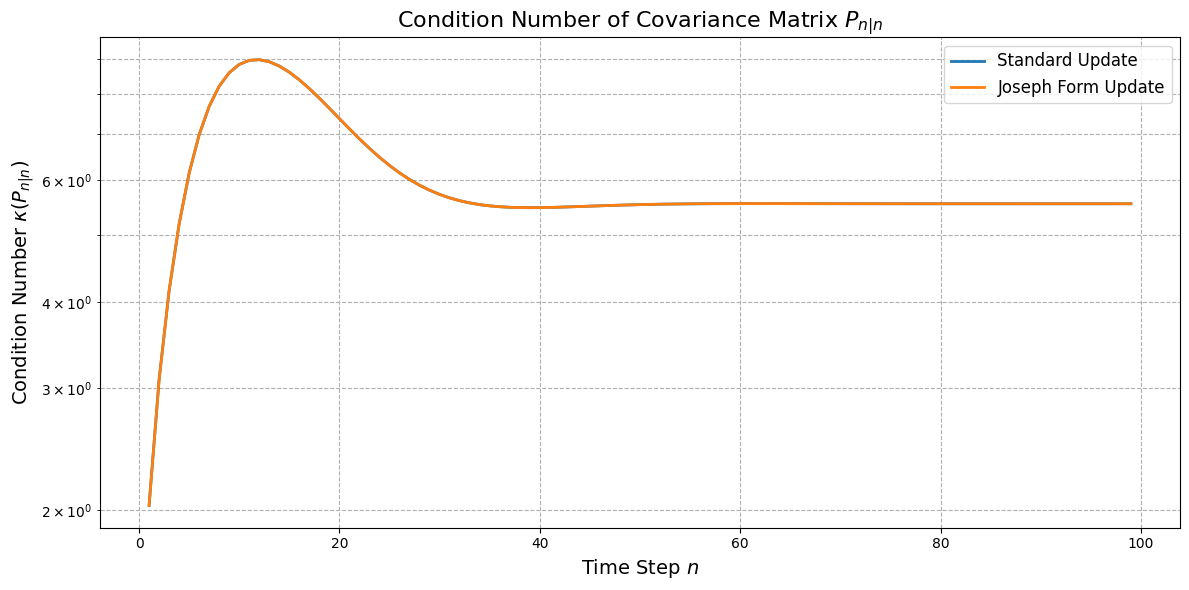

In [134]:

# Plot 2: Condition Number Comparison (Numerical Stability)
plt.figure(figsize=(12, 6))
plt.plot(range(1, N), cond_numbers_std, label='Standard Update', linewidth=2)
plt.plot(range(1, N), cond_numbers_joseph, label='Joseph Form Update', linewidth=2)
plt.title('Condition Number of Covariance Matrix $P_{n|n}$', fontsize=16)
plt.xlabel('Time Step $n$', fontsize=14)
plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

<>:187: SyntaxWarning: invalid escape sequence '\k'
<>:267: SyntaxWarning: invalid escape sequence '\h'
<>:187: SyntaxWarning: invalid escape sequence '\k'
<>:267: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-1651633805.py:187: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
/tmp/ipython-input-1651633805.py:267: SyntaxWarning: invalid escape sequence '\h'
  ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')


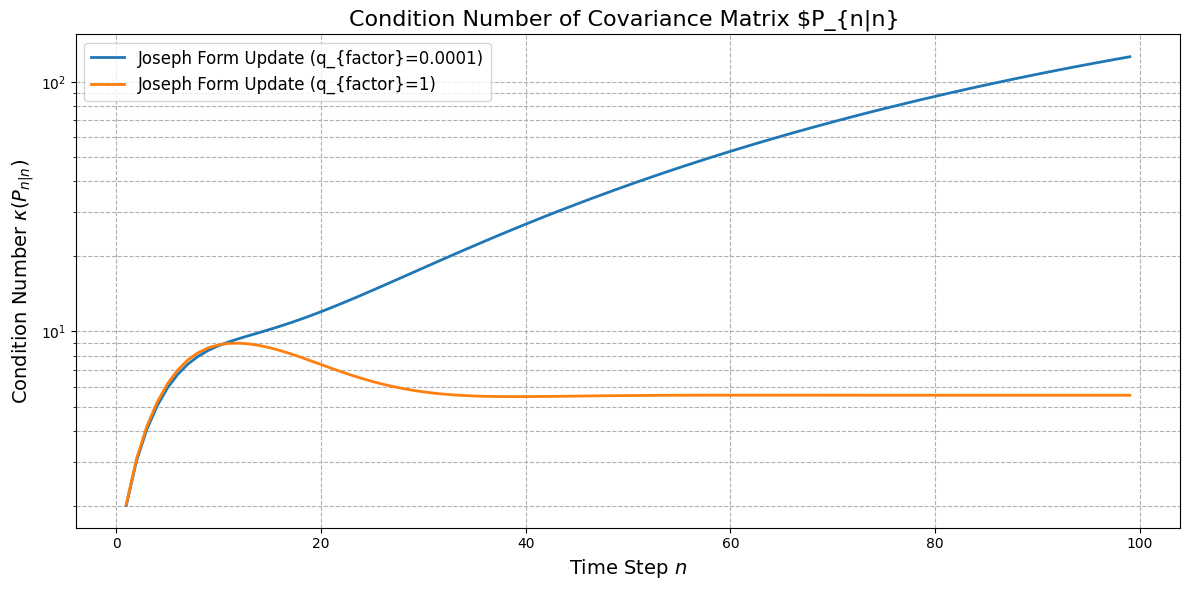

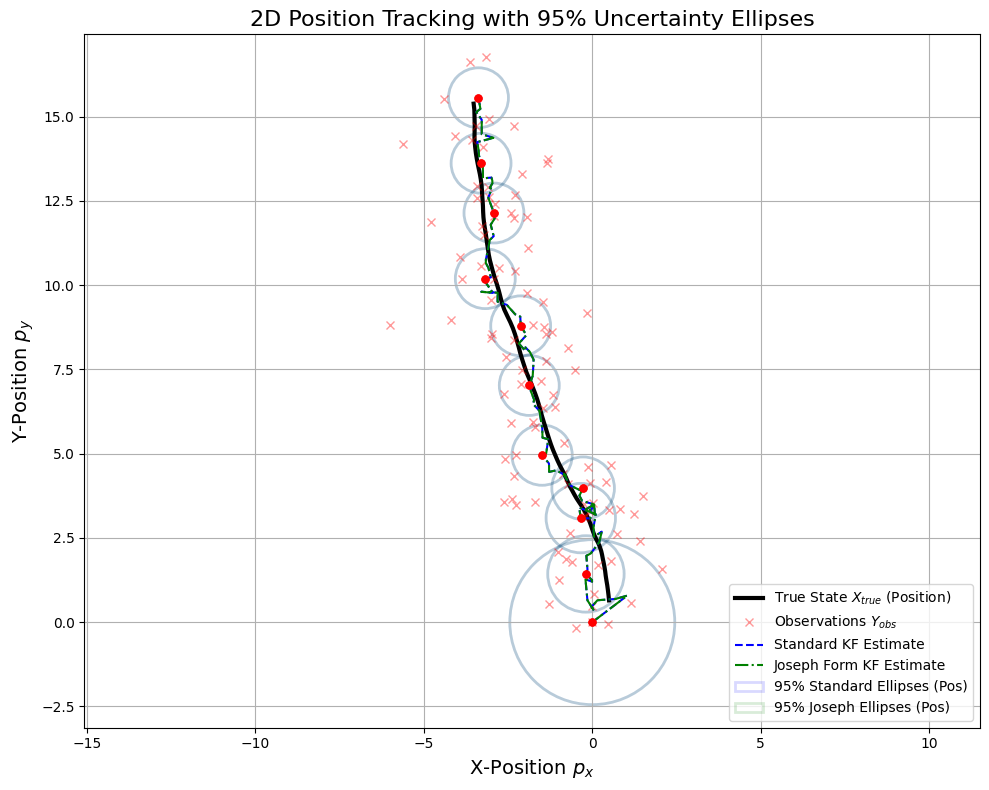

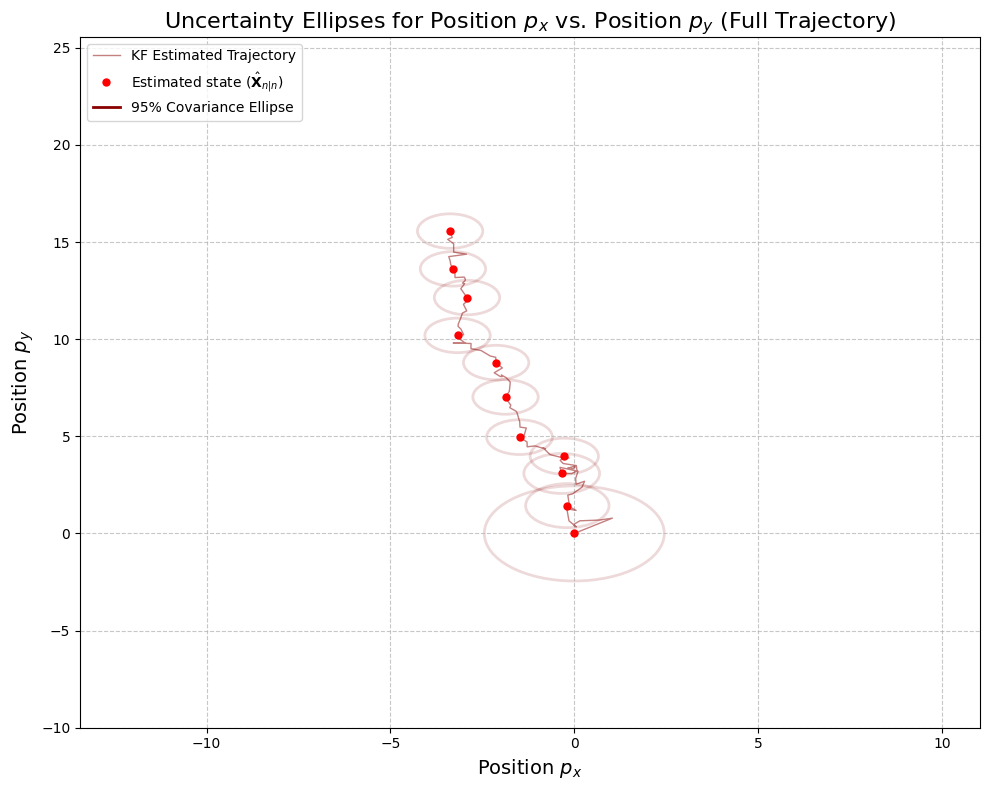

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse

# Set a seed for reproducibility of the synthetic data
np.random.seed(42)

# --- 1. Define Model Parameters (Matrices and Noise Covariances) ---
dt = 0.1  # Time step
N = 100 # Number of time steps
nx = 4 # State dimension: [p_x, v_x, p_y, v_y]
ny = 2 # Observation dimension: [p_x, p_y]
I = np.eye(nx)

# State Transition Matrix A (Constant Velocity Model)
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

# Process Noise Matrix B and Covariance Q
B = np.array([
    [dt**2/2, 0],
    [dt, 0],
    [0, dt**2/2],
    [0, dt]
])

# FIX FOR DIVERGENCE: Introduce a large scaling factor (q_factor) for the Process Noise Q.
# q_factor = 1000.0
Q = (B @ B.T)

# Observation Matrix C
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

# Observation Noise Matrix D and Covariance R
D = np.eye(2)
R = D @ D.T # Observation Noise Covariance R

# Initial Filter State and Covariance (used for both filter runs)
X0_filter = np.array([0.0, 0.0, 0.0, 0.0]) # Filter's initial state estimate
P0_filter = 1.0 * np.eye(4) # Initial Covariance P_{0|0}


# --- 2. Generate Synthetic Data ---
X_true = np.zeros((N, nx))
Y_obs = np.zeros((N, ny))

# True Initial State (Stochastic initial state for the *system*)
P0_true = 1.0 * np.eye(4)
mean_X0_true = np.zeros(nx)
L_P0_true = np.linalg.cholesky(P0_true)
X_true[0] = mean_X0_true + L_P0_true @ np.random.randn(nx)

# Simulate the process
for n in range(1, N):
    process_noise = (B @ np.random.randn(2))
    X_true[n] = A @ X_true[n-1] + process_noise

    observation_noise = (D @ np.random.randn(2))
    Y_obs[n] = C @ X_true[n] + observation_noise


# --- 3. Kalman Filter Function ---

def run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, update_type):
    N = Y_obs.shape[0]
    nx = A.shape[0]

    X_hat = np.zeros((N, nx))
    P_history = np.zeros((N, nx, nx))

    P = P0_filter
    X_hat[0] = X0_filter
    P_history[0] = P0_filter

    cond_numbers = []

    for n in range(1, N):
        X_hat_prior = A @ X_hat[n-1]
        P_prior = A @ P @ A.T + Q
        S = C @ P_prior @ C.T + R

        try:
            K = P_prior @ C.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            X_hat[n:] = np.nan
            break

        X_hat[n] = X_hat_prior + K @ (Y_obs[n] - C @ X_hat_prior)

        if update_type == 'standard':
            P = (I - K @ C) @ P_prior
        elif update_type == 'joseph':
            IC_KC = I - K @ C
            P = IC_KC @ P_prior @ IC_KC.T + K @ R @ K.T

        P_history[n] = P
        cond_number = np.linalg.cond(P)
        cond_numbers.append(cond_number)

    return X_hat, P_history, cond_numbers

# --- Helper Function for Plotting Covariance Ellipses ---
CHI2_VAL_95 = chi2.ppf(0.95, 2)

def plot_covariance_ellipse(ax, mean, P_submatrix, color, show_rho=False, label=None, filled=False, alpha=0.15):
    eigenvalues, eigenvectors = np.linalg.eigh(P_submatrix)

    if np.any(eigenvalues <= 0):
        ax.plot(mean[0], mean[1], marker='o', color=color, markersize=3)
        return

    s1 = np.sqrt(CHI2_VAL_95 * eigenvalues[0])
    s2 = np.sqrt(CHI2_VAL_95 * eigenvalues[1])
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    ellipse = Ellipse(xy=(mean[0], mean[1]), width=2 * s1, height=2 * s2,
                      angle=angle, color=color, linewidth=2 if not filled else 0, fill=filled, alpha=alpha)

    if label:
        ellipse.set_label(label)

    ax.add_patch(ellipse)

    if show_rho:
         ax.plot(mean[0], mean[1], 'ro', markersize=5, zorder=10)

    # if show_rho:
    #     std_dev_x = np.sqrt(P_submatrix[0, 0])
    #     std_dev_y = np.sqrt(P_submatrix[1, 1])
    #     if std_dev_x > 0 and std_dev_y > 0:
    #         rho = P_submatrix[0, 1] / (std_dev_x * std_dev_y)
    #         ax.text(mean[0] + 0.15 * s1, mean[1] - 0.15 * s2, f'$\\rho$={rho:.f}',
    #                 fontsize=10, color='darkred', ha='left', va='center')
def confidence_ellipse(ax, mu, P, color, n_std=2.0, facecolor='none', show_rho=False, label=None, filled=False, alpha=0.15):
    """
    Plots a confidence ellipse based on the covariance matrix P.

    mu: The 2D mean vector [x, y] (in our case [position, velocity]).
    P: The 2x2 covariance matrix.
    ax: The matplotlib axis object to draw on.
    n_std: The number of standard deviations for the ellipse size
           (e.g., 3.0 covers ~99.7% for a 2D Gaussian).
    """

    # 1. Calculate eigenvalues and eigenvectors of the covariance matrix P
    # These determine the magnitude and orientation of the ellipse axes.
    eig_vals, eig_vecs = np.linalg.eigh(P)

    # 2. Calculate the angle of rotation for the ellipse (eigenvector for the largest eigenvalue)
    # The angle is the orientation of the major axis.
    angle = np.degrees(np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0]))

    # 3. Determine the width and height of the ellipse
    # The axes lengths are determined by the square root of the eigenvalues
    # and scaled by the confidence factor (n_std).
    width, height = 2 * n_std * np.sqrt(eig_vals)

    # 4. Create the Ellipse patch object
    ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle, color=color,
                      facecolor=facecolor, linewidth=2 if not filled else 0, fill=filled, alpha=alpha)

    # 5. Add the ellipse to the plot and return it
    return ax.add_patch(ellipse)

# --- 4. Run Comparisons ---
X_hat_std, P_std, cond_numbers_std1 = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'standard')
X_hat_joseph, P_joseph, cond_numbers_joseph1 = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'joseph')


# --- 5. Plotting Results ---

# --- Plot 1: Condition Number Comparison (Numerical Stability) ---
plt.figure(figsize=(12, 6))
# plt.plot(range(1, N), cond_numbers_std1, label='Standard Update', linewidth=2)
plt.plot(range(1, N), cond_numbers_joseph, label='Joseph Form Update (q_{factor}=0.0001)', linewidth=2)
plt.plot(range(1, N), cond_numbers_joseph1, label='Joseph Form Update (q_{factor}=1)', linewidth=2)
plt.title('Condition Number of Covariance Matrix $P_{n|n} ', fontsize=16)
plt.xlabel('Time Step $n$', fontsize=14)
plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- Plot 2: Tracking Comparison with Uncertainty Ellipses (Position only) ---
fig, ax = plt.subplots(figsize=(10, 8))

# True State (Position)
ax.plot(X_true[:, 0], X_true[:, 2], 'k-', linewidth=3, label='True State $X_{true}$ (Position)')

# Noisy Observations
ax.plot(Y_obs[:, 0], Y_obs[:, 1], 'rx', alpha=0.4, label='Observations $Y_{obs}$')

# Kalman Filter Estimates
ax.plot(X_hat_std[:, 0], X_hat_std[:, 2], 'b--', linewidth=1.5, label='Standard KF Estimate')
ax.plot(X_hat_joseph[:, 0], X_hat_joseph[:, 2], 'g-.', linewidth=1.5, label='Joseph Form KF Estimate')

# --- Draw Covariance Ellipses (Position Only) ---
plot_steps_pos = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

for n in plot_steps_pos:
    mean_std_pos = X_hat_std[n, [0, 2]] # [px, py] mean estimate
    P_pos_std = P_std[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_std_pos = '95% Standard Ellipses (Pos)' if n == plot_steps_pos[0] else None
    # confidence_ellipse(ax, mean_std_pos, P_pos_std, 'blue', label=label_std_pos)
    plot_covariance_ellipse(ax, mean_std_pos, P_pos_std, 'blue', label=label_std_pos, show_rho=True)

    mean_joseph_pos = X_hat_joseph[n, [0, 2]] # [px, py] mean estimate
    P_pos_joseph = P_joseph[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_joseph_pos = '95% Joseph Ellipses (Pos)' if n == plot_steps_pos[0] else None
    # confidence_ellipse(ax, mean_joseph_pos, P_pos_joseph, 'green', label=label_joseph_pos)
    plot_covariance_ellipse(ax, mean_joseph_pos, P_pos_joseph, 'green', label=label_joseph_pos, show_rho=True)


ax.set_title('2D Position Tracking with 95% Uncertainty Ellipses', fontsize=16)
ax.set_xlabel('X-Position $p_x$', fontsize=14)
ax.set_ylabel('Y-Position $p_y$', fontsize=14)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True)
ax.axis('equal')
plt.tight_layout()
plt.show()

# --- Plot 3: Position (px) vs Position (py) Uncertainty Ellipses (The fix for inconsistency) ---
fig_pp, ax_pp = plt.subplots(figsize=(10, 8))

# Use plot_steps_pos to ensure coverage across the entire trajectory
plot_steps_pp = plot_steps_pos

# Indices for Px and Py in the 4-state vector [px, vx, py, vy]
px_idx = 0
py_idx = 2
color_pp = 'darkred'

ax_pp.set_title('Uncertainty Ellipses for Position $p_x$ vs. Position $p_y$ (Full Trajectory)', fontsize=16)
ax_pp.set_xlabel('Position $p_x$', fontsize=14)
ax_pp.set_ylabel('Position $p_y$', fontsize=14)
ax_pp.grid(True, linestyle='--', alpha=0.7)

# Plot the full trajectory as a thin line for context
ax_pp.plot(X_hat_joseph[:, px_idx], X_hat_joseph[:, py_idx], color_pp, linewidth=1, alpha=0.5, label='KF Estimated Trajectory')


# Plot the Joseph Form ellipses across the full trajectory
for n in plot_steps_pp:
    # Extract mean for (px, py)
    mean_pp = X_hat_joseph[n, [px_idx, py_idx]]

    # Extract 2x2 covariance sub-matrix for (px, py)
    P_pp = P_joseph[n, [px_idx, py_idx], :][:, [px_idx, py_idx]]

    # Plot ellipse with mean (red dot) and correlation rho (hollow ellipse)
    plot_covariance_ellipse(ax_pp, mean_pp, P_pp, color_pp, show_rho=True)

# Create custom proxy artists for the final legend
ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')
ax_pp.plot([], [], color=color_pp, linewidth=2, label='95% Covariance Ellipse')
# ax_pp.plot([], [], 'w', label='$\\rho$: Pearson correlation coefficient')

ax_pp.legend(fontsize=10, loc='upper left')

# Set limits to match the full extent of the trajectory
ax_pp.set_xlim(np.min(X_hat_joseph[:, px_idx]) - 10, np.max(X_hat_joseph[:, px_idx]) + 10)
ax_pp.set_ylim(np.min(X_hat_joseph[:, py_idx]) - 10, np.max(X_hat_joseph[:, py_idx]) + 10)

plt.tight_layout()
plt.show()

<>:186: SyntaxWarning: invalid escape sequence '\k'
<>:266: SyntaxWarning: invalid escape sequence '\h'
<>:186: SyntaxWarning: invalid escape sequence '\k'
<>:266: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-1585489924.py:186: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
/tmp/ipython-input-1585489924.py:266: SyntaxWarning: invalid escape sequence '\h'
  ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')


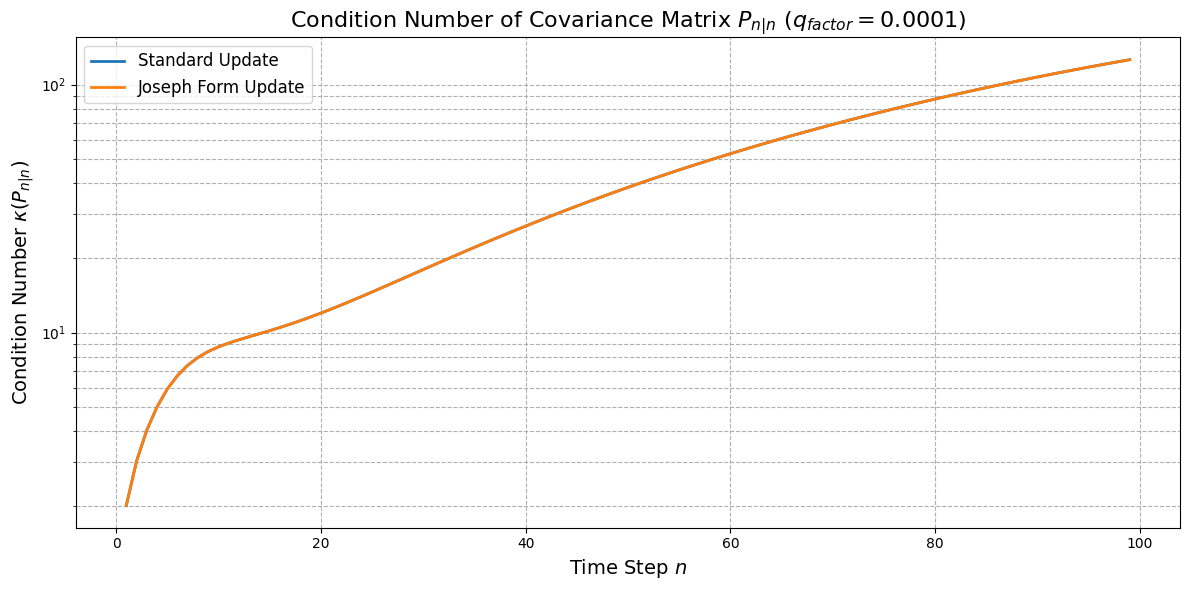

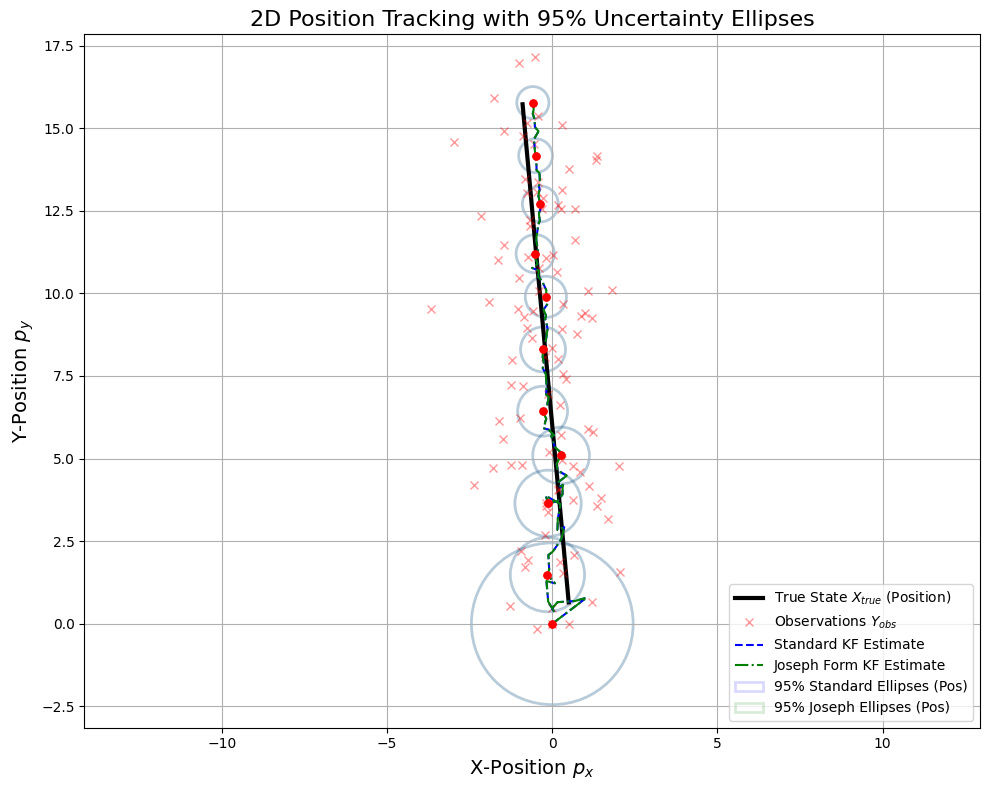

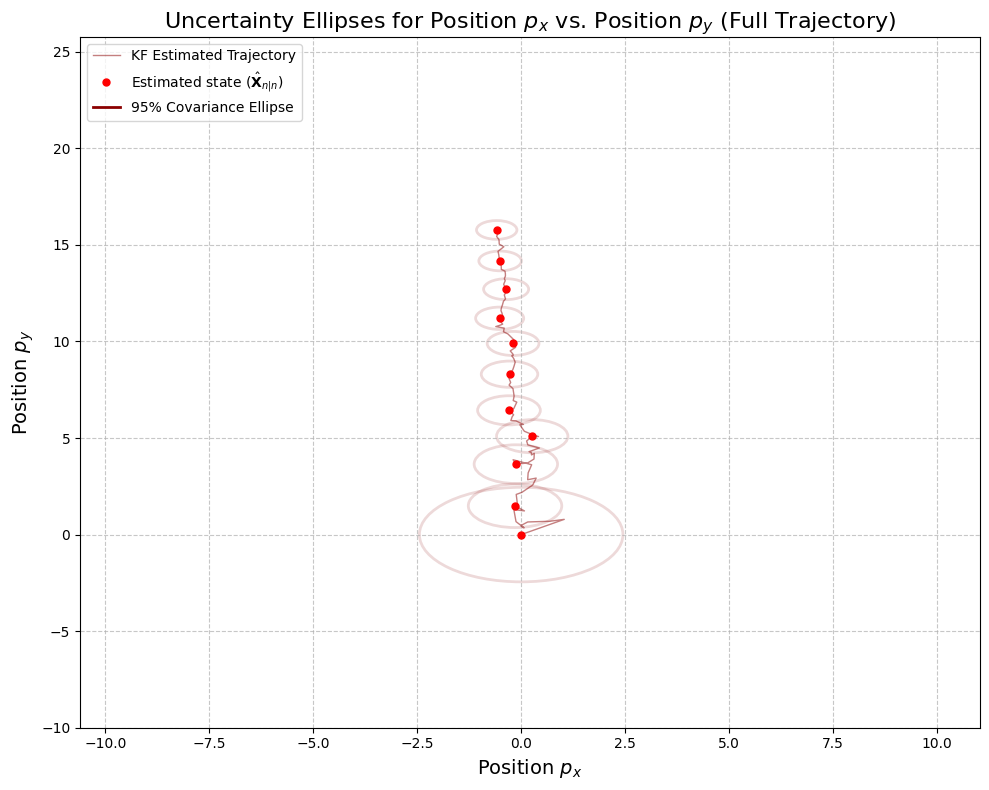

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse

# Set a seed for reproducibility of the synthetic data
np.random.seed(42)

# --- 1. Define Model Parameters (Matrices and Noise Covariances) ---
dt = 0.1  # Time step
N = 100 # Number of time steps
nx = 4 # State dimension: [p_x, v_x, p_y, v_y]
ny = 2 # Observation dimension: [p_x, p_y]
I = np.eye(nx)

# State Transition Matrix A (Constant Velocity Model)
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

# Process Noise Matrix B and Covariance Q
B = np.array([
    [dt**2/2, 0],
    [dt, 0],
    [0, dt**2/2],
    [0, dt]
])

# FIX FOR DIVERGENCE: Introduce a large scaling factor (q_factor) for the Process Noise Q.
q_factor = 0.0001
Q = q_factor * (B @ B.T)

# Observation Matrix C
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

# Observation Noise Matrix D and Covariance R
D = np.eye(2)
R = D @ D.T # Observation Noise Covariance R

# Initial Filter State and Covariance (used for both filter runs)
X0_filter = np.array([0.0, 0.0, 0.0, 0.0]) # Filter's initial state estimate
P0_filter = 1.0 * np.eye(4) # Initial Covariance P_{0|0}


# --- 2. Generate Synthetic Data ---
X_true = np.zeros((N, nx))
Y_obs = np.zeros((N, ny))

# True Initial State (Stochastic initial state for the *system*)
P0_true = 1.0 * np.eye(4)
mean_X0_true = np.zeros(nx)
L_P0_true = np.linalg.cholesky(P0_true)
X_true[0] = mean_X0_true + L_P0_true @ np.random.randn(nx)

# Simulate the process
for n in range(1, N):
    process_noise = np.sqrt(q_factor) * (B @ np.random.randn(2))
    X_true[n] = A @ X_true[n-1] + process_noise

    observation_noise = (D @ np.random.randn(2))
    Y_obs[n] = C @ X_true[n] + observation_noise


# --- 3. Kalman Filter Function ---

def run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, update_type):
    N = Y_obs.shape[0]
    nx = A.shape[0]

    X_hat = np.zeros((N, nx))
    P_history = np.zeros((N, nx, nx))

    P = P0_filter
    X_hat[0] = X0_filter
    P_history[0] = P0_filter

    cond_numbers = []

    for n in range(1, N):
        X_hat_prior = A @ X_hat[n-1]
        P_prior = A @ P @ A.T + Q
        S = C @ P_prior @ C.T + R

        try:
            K = P_prior @ C.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            X_hat[n:] = np.nan
            break

        X_hat[n] = X_hat_prior + K @ (Y_obs[n] - C @ X_hat_prior)

        if update_type == 'standard':
            P = (I - K @ C) @ P_prior
        elif update_type == 'joseph':
            IC_KC = I - K @ C
            P = IC_KC @ P_prior @ IC_KC.T + K @ R @ K.T

        P_history[n] = P
        cond_number = np.linalg.cond(P)
        cond_numbers.append(cond_number)

    return X_hat, P_history, cond_numbers

# --- Helper Function for Plotting Covariance Ellipses ---
CHI2_VAL_95 = chi2.ppf(0.95, 2)

def plot_covariance_ellipse(ax, mean, P_submatrix, color, show_rho=False, label=None, filled=False, alpha=0.15):
    eigenvalues, eigenvectors = np.linalg.eigh(P_submatrix)

    if np.any(eigenvalues <= 0):
        ax.plot(mean[0], mean[1], marker='o', color=color, markersize=3)
        return

    s1 = np.sqrt(CHI2_VAL_95 * eigenvalues[0])
    s2 = np.sqrt(CHI2_VAL_95 * eigenvalues[1])
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    ellipse = Ellipse(xy=(mean[0], mean[1]), width=2 * s1, height=2 * s2,
                      angle=angle, color=color, linewidth=2 if not filled else 0, fill=filled, alpha=alpha)

    if label:
        ellipse.set_label(label)

    ax.add_patch(ellipse)

    if show_rho:
         ax.plot(mean[0], mean[1], 'ro', markersize=5, zorder=10)

    # if show_rho:
    #     std_dev_x = np.sqrt(P_submatrix[0, 0])
    #     std_dev_y = np.sqrt(P_submatrix[1, 1])
    #     if std_dev_x > 0 and std_dev_y > 0:
    #         rho = P_submatrix[0, 1] / (std_dev_x * std_dev_y)
    #         ax.text(mean[0] + 0.15 * s1, mean[1] - 0.15 * s2, f'$\\rho$={rho:.f}',
    #                 fontsize=10, color='darkred', ha='left', va='center')
# def confidence_ellipse(ax, mu, P, color, n_std=2.0, facecolor='none', show_rho=False, label=None, filled=False, alpha=0.15):
#     """
#     Plots a confidence ellipse based on the covariance matrix P.

#     mu: The 2D mean vector [x, y] (in our case [position, velocity]).
#     P: The 2x2 covariance matrix.
#     ax: The matplotlib axis object to draw on.
#     n_std: The number of standard deviations for the ellipse size
#            (e.g., 3.0 covers ~99.7% for a 2D Gaussian).
#     """

#     # 1. Calculate eigenvalues and eigenvectors of the covariance matrix P
#     # These determine the magnitude and orientation of the ellipse axes.
#     eig_vals, eig_vecs = np.linalg.eigh(P)

#     # 2. Calculate the angle of rotation for the ellipse (eigenvector for the largest eigenvalue)
#     # The angle is the orientation of the major axis.
#     angle = np.degrees(np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0]))

#     # 3. Determine the width and height of the ellipse
#     # The axes lengths are determined by the square root of the eigenvalues
#     # and scaled by the confidence factor (n_std).
#     width, height = 2 * n_std * np.sqrt(eig_vals)

#     # 4. Create the Ellipse patch object
#     ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle, color=color,
#                       facecolor=facecolor, linewidth=2 if not filled else 0, fill=filled, alpha=alpha)

#     # 5. Add the ellipse to the plot and return it
#     return ax.add_patch(ellipse)

# --- 4. Run Comparisons ---
X_hat_std, P_std, cond_numbers_std = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'standard')
X_hat_joseph, P_joseph, cond_numbers_joseph = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'joseph')


# --- 5. Plotting Results ---

# --- Plot 1: Condition Number Comparison (Numerical Stability) ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, N), cond_numbers_std, label='Standard Update', linewidth=2)
plt.plot(range(1, N), cond_numbers_joseph, label='Joseph Form Update', linewidth=2)
plt.title('Condition Number of Covariance Matrix $P_{n|n}$ ($q_{factor} = 0.0001$)', fontsize=16)
plt.xlabel('Time Step $n$', fontsize=14)
plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- Plot 2: Tracking Comparison with Uncertainty Ellipses (Position only) ---
fig, ax = plt.subplots(figsize=(10, 8))

# True State (Position)
ax.plot(X_true[:, 0], X_true[:, 2], 'k-', linewidth=3, label='True State $X_{true}$ (Position)')

# Noisy Observations
ax.plot(Y_obs[:, 0], Y_obs[:, 1], 'rx', alpha=0.4, label='Observations $Y_{obs}$')

# Kalman Filter Estimates
ax.plot(X_hat_std[:, 0], X_hat_std[:, 2], 'b--', linewidth=1.5, label='Standard KF Estimate')
ax.plot(X_hat_joseph[:, 0], X_hat_joseph[:, 2], 'g-.', linewidth=1.5, label='Joseph Form KF Estimate')

# --- Draw Covariance Ellipses (Position Only) ---
plot_steps_pos = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

for n in plot_steps_pos:
    mean_std_pos = X_hat_std[n, [0, 2]] # [px, py] mean estimate
    P_pos_std = P_std[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_std_pos = '95% Standard Ellipses (Pos)' if n == plot_steps_pos[0] else None
    # confidence_ellipse(ax, mean_std_pos, P_pos_std, 'blue', label=label_std_pos)
    plot_covariance_ellipse(ax, mean_std_pos, P_pos_std, 'blue', label=label_std_pos, show_rho=True)

    mean_joseph_pos = X_hat_joseph[n, [0, 2]] # [px, py] mean estimate
    P_pos_joseph = P_joseph[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_joseph_pos = '95% Joseph Ellipses (Pos)' if n == plot_steps_pos[0] else None
    # confidence_ellipse(ax, mean_joseph_pos, P_pos_joseph, 'green', label=label_joseph_pos)
    plot_covariance_ellipse(ax, mean_joseph_pos, P_pos_joseph, 'green', label=label_joseph_pos, show_rho=True)


ax.set_title('2D Position Tracking with 95% Uncertainty Ellipses', fontsize=16)
ax.set_xlabel('X-Position $p_x$', fontsize=14)
ax.set_ylabel('Y-Position $p_y$', fontsize=14)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True)
ax.axis('equal')
plt.tight_layout()
plt.show()

# --- Plot 3: Position (px) vs Position (py) Uncertainty Ellipses (The fix for inconsistency) ---
fig_pp, ax_pp = plt.subplots(figsize=(10, 8))

# Use plot_steps_pos to ensure coverage across the entire trajectory
plot_steps_pp = plot_steps_pos

# Indices for Px and Py in the 4-state vector [px, vx, py, vy]
px_idx = 0
py_idx = 2
color_pp = 'darkred'

ax_pp.set_title('Uncertainty Ellipses for Position $p_x$ vs. Position $p_y$ (Full Trajectory)', fontsize=16)
ax_pp.set_xlabel('Position $p_x$', fontsize=14)
ax_pp.set_ylabel('Position $p_y$', fontsize=14)
ax_pp.grid(True, linestyle='--', alpha=0.7)

# Plot the full trajectory as a thin line for context
ax_pp.plot(X_hat_joseph[:, px_idx], X_hat_joseph[:, py_idx], color_pp, linewidth=1, alpha=0.5, label='KF Estimated Trajectory')


# Plot the Joseph Form ellipses across the full trajectory
for n in plot_steps_pp:
    # Extract mean for (px, py)
    mean_pp = X_hat_joseph[n, [px_idx, py_idx]]

    # Extract 2x2 covariance sub-matrix for (px, py)
    P_pp = P_joseph[n, [px_idx, py_idx], :][:, [px_idx, py_idx]]

    # Plot ellipse with mean (red dot) and correlation rho (hollow ellipse)
    plot_covariance_ellipse(ax_pp, mean_pp, P_pp, color_pp, show_rho=True)

# Create custom proxy artists for the final legend
ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')
ax_pp.plot([], [], color=color_pp, linewidth=2, label='95% Covariance Ellipse')
# ax_pp.plot([], [], 'w', label='$\\rho$: Pearson correlation coefficient')

ax_pp.legend(fontsize=10, loc='upper left')

# Set limits to match the full extent of the trajectory
ax_pp.set_xlim(np.min(X_hat_joseph[:, px_idx]) - 10, np.max(X_hat_joseph[:, px_idx]) + 10)
ax_pp.set_ylim(np.min(X_hat_joseph[:, py_idx]) - 10, np.max(X_hat_joseph[:, py_idx]) + 10)

plt.tight_layout()
plt.show()

<>:165: SyntaxWarning: invalid escape sequence '\k'
<>:239: SyntaxWarning: invalid escape sequence '\h'
<>:165: SyntaxWarning: invalid escape sequence '\k'
<>:239: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-4033803915.py:165: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
/tmp/ipython-input-4033803915.py:239: SyntaxWarning: invalid escape sequence '\h'
  ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')


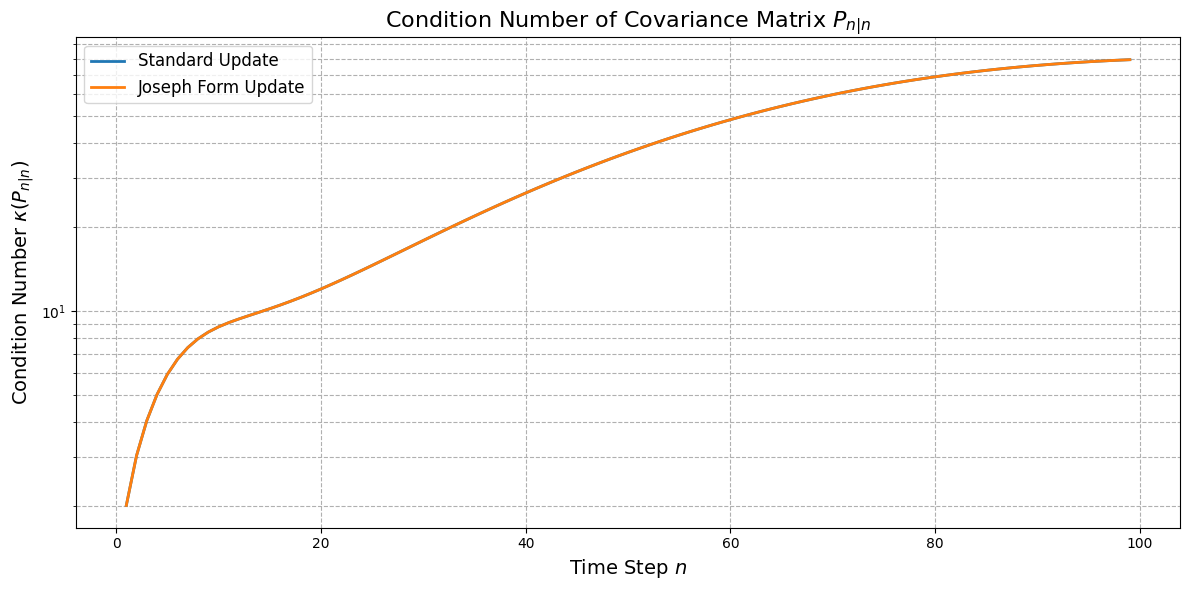

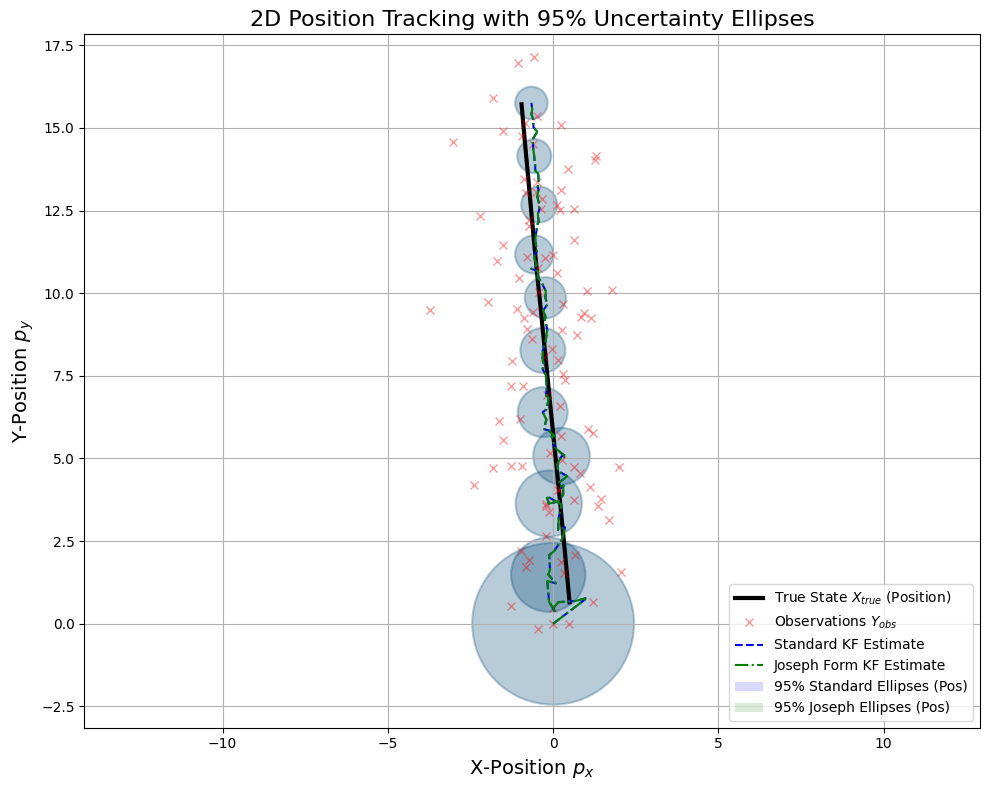

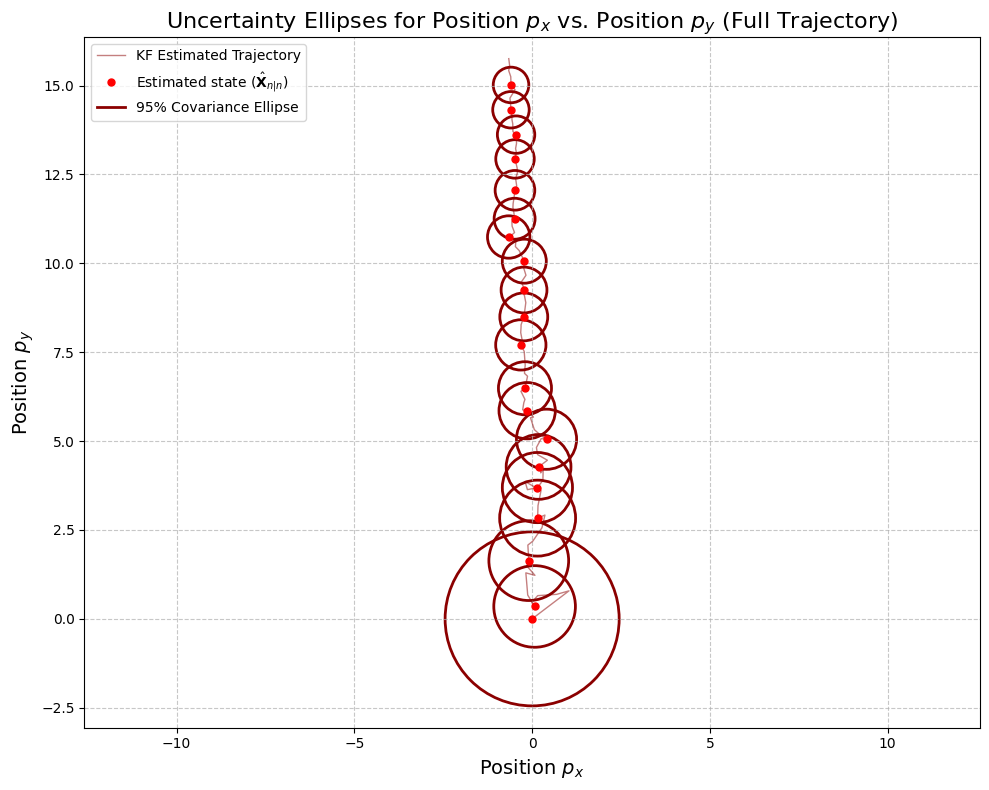

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Set a seed for reproducibility of the synthetic data
np.random.seed(42)

# --- 1. Define Model Parameters (Matrices and Noise Covariances) ---
dt = 0.1  # Time step
N = 100 # Number of time steps
nx = 4 # State dimension: [p_x, v_x, p_y, v_y]
ny = 2 # Observation dimension: [p_x, p_y]
I = np.eye(nx)

# State Transition Matrix A (Constant Velocity Model)
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

# Process Noise Matrix B and Covariance Q
B = np.array([
    [dt**2/2, 0],
    [dt, 0],
    [0, dt**2/2],
    [0, dt]
])

# FIX FOR DIVERGENCE: Introduce a scaling factor for the Process Noise Q.
q_factor = 0.001
Q_base = B @ B.T
Q = q_factor * Q_base

# Observation Matrix C
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

# Observation Noise Matrix D and Covariance R
D = np.eye(2)
R = D @ D.T # Observation Noise Covariance R

# Initial Filter State and Covariance (used for both filter runs)
X0_filter = np.array([0.0, 0.0, 0.0, 0.0]) # Filter's initial state estimate
P0_filter = 1.0 * np.eye(4) # Initial Covariance P_{0|0}


# --- 2. Generate Synthetic Data ---
X_true = np.zeros((N, nx))
Y_obs = np.zeros((N, ny))

# True Initial State (Stochastic initial state for the *system*)
P0_true = 1.0 * np.eye(4)
mean_X0_true = np.zeros(nx)
L_P0_true = np.linalg.cholesky(P0_true)
X_true[0] = mean_X0_true + L_P0_true @ np.random.randn(nx)

# Simulate the process
for n in range(1, N):
    # The noise magnitude should match the covariance magnitude, P = E[w w^T] = Q
    process_noise = np.sqrt(q_factor) * (B @ np.random.randn(2))
    X_true[n] = A @ X_true[n-1] + process_noise

    observation_noise = (D @ np.random.randn(2))
    Y_obs[n] = C @ X_true[n] + observation_noise


# --- 3. Kalman Filter Function ---

def run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, update_type):
    N = Y_obs.shape[0]
    nx = A.shape[0]

    X_hat = np.zeros((N, nx))
    P_history = np.zeros((N, nx, nx))

    P = P0_filter
    X_hat[0] = X0_filter
    P_history[0] = P0_filter

    cond_numbers = []

    for n in range(1, N):
        X_hat_prior = A @ X_hat[n-1]

        P_prior = A @ P @ A.T + Q
        S = C @ P_prior @ C.T + R

        try:
            K = P_prior @ C.T @ np.linalg.inv(S)
        except np.linalg.LinAlgError:
            X_hat[n:] = np.nan
            break

        X_hat[n] = X_hat_prior + K @ (Y_obs[n] - C @ X_hat_prior)

        if update_type == 'standard':
            P = (I - K @ C) @ P_prior
        elif update_type == 'joseph':
            IC_KC = I - K @ C
            P = IC_KC @ P_prior @ IC_KC.T + K @ R @ K.T

        P_history[n] = P
        cond_number = np.linalg.cond(P)
        cond_numbers.append(cond_number)

    return X_hat, P_history, cond_numbers

# --- Helper Function for Plotting Covariance Ellipses ---
CHI2_VAL_95 = chi2.ppf(0.95, 2)

def plot_confidence_ellipse(ax, mean, P_submatrix, color, show_mean_dot=False, label=None, linewidth=2.0, alpha=0.15, filled=False):
    """
    Plots a confidence ellipse using the Chi-squared value for the 95% confidence level.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(P_submatrix)

    if np.any(eigenvalues <= 0):
        if show_mean_dot:
            ax.plot(mean[0], mean[1], marker='o', color=color, markersize=3)
        return

    # 1. Calculate semi-axes lengths using the Chi-squared factor
    s1 = np.sqrt(CHI2_VAL_95 * eigenvalues[0])
    s2 = np.sqrt(CHI2_VAL_95 * eigenvalues[1])

    # 2. Calculate the rotation angle
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    # 3. Create the Ellipse object
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=2 * s1, height=2 * s2,
                      angle=angle,
                      edgecolor=color,
                      facecolor=color if filled else 'none',
                      linewidth=linewidth,
                      fill=filled,
                      alpha=alpha)

    # 4. Add the ellipse to the axes
    ax.add_patch(ellipse)

    # 5. Plot the estimated mean (red dot) if requested
    if show_mean_dot:
         ax.plot(mean[0], mean[1], 'ro', markersize=5, zorder=10)


# --- 4. Run Comparisons (Unchanged) ---
X_hat_std, P_std, cond_numbers_std = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'standard')
X_hat_joseph, P_joseph, cond_numbers_joseph = run_kalman_filter(Y_obs, A, Q, C, R, X0_filter, P0_filter, 'joseph')


# --- 5. Plotting Results ---

# --- Plot 1: Condition Number Comparison (Numerical Stability) ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, N), cond_numbers_std, label='Standard Update', linewidth=2)
plt.plot(range(1, N), cond_numbers_joseph, label='Joseph Form Update', linewidth=2)
plt.title('Condition Number of Covariance Matrix $P_{n|n}$', fontsize=16)
plt.xlabel('Time Step $n$', fontsize=14)
plt.ylabel('Condition Number $\kappa(P_{n|n})$', fontsize=14)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- Plot 2: Tracking Comparison with Uncertainty Ellipses (Position only) ---
fig, ax = plt.subplots(figsize=(10, 8))

# True State (Position)
ax.plot(X_true[:, 0], X_true[:, 2], 'k-', linewidth=3, label='True State $X_{true}$ (Position)')

# Noisy Observations
ax.plot(Y_obs[:, 0], Y_obs[:, 1], 'rx', alpha=0.4, label='Observations $Y_{obs}$')

# Kalman Filter Estimates
ax.plot(X_hat_std[:, 0], X_hat_std[:, 2], 'b--', linewidth=1.5, label='Standard KF Estimate')
ax.plot(X_hat_joseph[:, 0], X_hat_joseph[:, 2], 'g-.', linewidth=1.5, label='Joseph Form KF Estimate')

# --- Draw Covariance Ellipses (Position Only) ---
plot_steps_pos = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]

for n in plot_steps_pos:
    mean_std_pos = X_hat_std[n, [0, 2]] # [px, py] mean estimate
    P_pos_std = P_std[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_std_pos = '95% Standard Ellipses (Pos)' if n == plot_steps_pos[0] else None
    plot_confidence_ellipse(ax, mean_std_pos, P_pos_std, 'blue', linewidth=1.5, alpha=0.15, filled=True)

    mean_joseph_pos = X_hat_joseph[n, [0, 2]] # [px, py] mean estimate
    P_pos_joseph = P_joseph[n, [0, 2], :][:, [0, 2]] # 2x2 position covariance block

    label_joseph_pos = '95% Joseph Ellipses (Pos)' if n == plot_steps_pos[0] else None
    plot_confidence_ellipse(ax, mean_joseph_pos, P_pos_joseph, 'green', linewidth=1.5, alpha=0.15, filled=True)

# --- Legend Proxies for Ellipses ---
ax.add_patch(Ellipse((0,0), 0, 0, facecolor='blue', alpha=0.15, label='95% Standard Ellipses (Pos)'))
ax.add_patch(Ellipse((0,0), 0, 0, facecolor='green', alpha=0.15, label='95% Joseph Ellipses (Pos)'))
ax.set_title('2D Position Tracking with 95% Uncertainty Ellipses', fontsize=16)
ax.set_xlabel('X-Position $p_x$', fontsize=14)
ax.set_ylabel('Y-Position $p_y$', fontsize=14)
ax.legend(fontsize=10, loc='lower right')
ax.grid(True)
ax.axis('equal')
plt.tight_layout()
plt.show()

# --- Plot 3: Position (px) vs Position (py) Uncertainty Ellipses (Corrected Plot) ---
fig_pp, ax_pp = plt.subplots(figsize=(10, 8))

plot_steps_pp = np.arange(0, N, 5) # Plot every 5th step
px_idx = 0
py_idx = 2
color_pp = 'darkred'

ax_pp.set_title('Uncertainty Ellipses for Position $p_x$ vs. Position $p_y$ (Full Trajectory)', fontsize=16)
ax_pp.set_xlabel('Position $p_x$', fontsize=14)
ax_pp.set_ylabel('Position $p_y$', fontsize=14)
ax_pp.grid(True, linestyle='--', alpha=0.7)

# Plot the full trajectory as a thin line for context
ax_pp.plot(X_hat_joseph[:, px_idx], X_hat_joseph[:, py_idx], color=color_pp, linewidth=1, alpha=0.5, label='KF Estimated Trajectory')


# Plot the Joseph Form ellipses across the full trajectory
for n in plot_steps_pp:
    mean_pp = X_hat_joseph[n, [px_idx, py_idx]]
    P_pp = P_joseph[n, [px_idx, py_idx], :][:, [px_idx, py_idx]]

    # Use full opacity (alpha=1.0) and show mean dot
    plot_confidence_ellipse(ax_pp, mean_pp, P_pp, color=color_pp, show_mean_dot=True, linewidth=2, alpha=1.0)

# Create custom proxy artists for the final legend
ax_pp.plot([], [], 'ro', markersize=5, label='Estimated state ($\hat{\mathbf{X}}_{n|n}$)')
ax_pp.plot([], [], color=color_pp, linewidth=2, label='95% Covariance Ellipse')

ax_pp.legend(fontsize=10, loc='upper left')

# Set limits dynamically but add padding
x_min, x_max = np.min(X_hat_joseph[:, px_idx]), np.max(X_hat_joseph[:, px_idx])
y_min, y_max = np.min(X_hat_joseph[:, py_idx]), np.max(X_hat_joseph[:, py_idx])
ax_pp.set_xlim(x_min - 2, x_max + 2)
ax_pp.set_ylim(y_min - 2, y_max + 2)
ax_pp.axis('equal') # Ensure circles look like circles

plt.tight_layout()
plt.show()

## II) Nonlinear/Non-Gaussian SSM with EKF/UKF and Particle Filter

### a)	Design a nonlinear and non-Gaussian SSM, you can use a stochastic volatility model (example 4 in [Doucet(09)]) or nonlinear tracking models(e.g. Range-Bearing observation model)

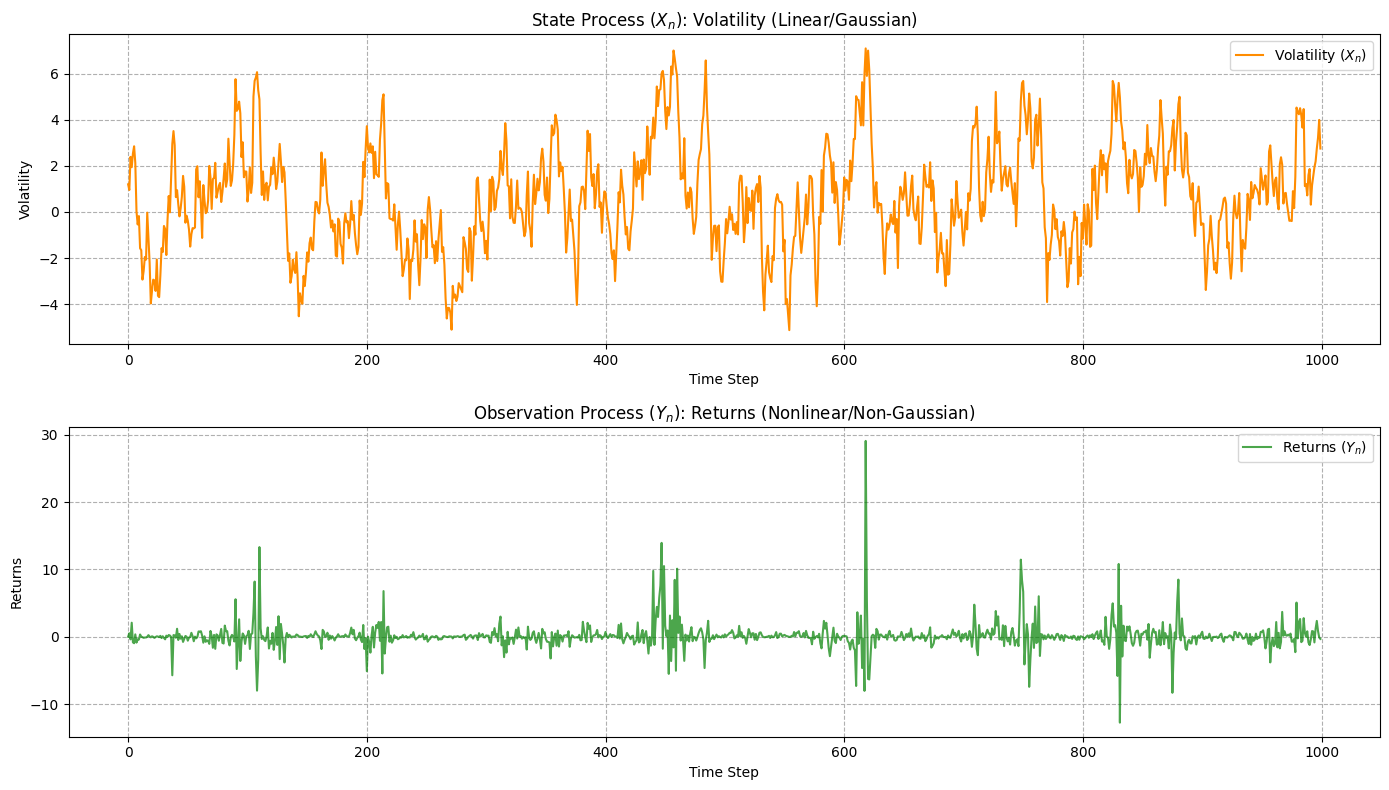

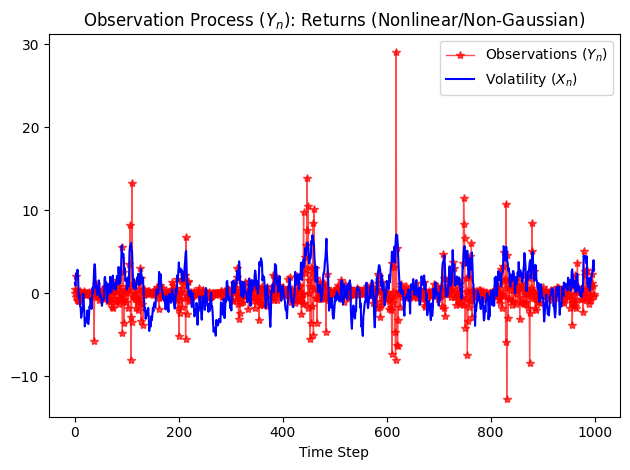

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Model Parameters ---

# SV Model Parameters (the same as example 4)
alpha = 0.91 # Persistence of volatility
sigma = 1.0  # Volatility of the log-volatility process
beta = 0.5   # Scaling factor for returns

# Initial State Distribution (X_1)
# Ensures marginal distribution of X_n is stationary N(0, sigma^2 / (1 - alpha^2))
sigma_sq_stationary = sigma**2 / (1 - alpha**2)
X1_mean = 0.0
X1_std = np.sqrt(sigma_sq_stationary)

# Time steps
N_steps = 500

print(f"SV Model Initial State Distribution: N({X1_mean:.2f}, {sigma_sq_stationary:.2f})")
print(f"Observation noise scale factor (beta): {beta}")

# --- 2. Synthetic Data Generation ---

# Initialize arrays
X_true = np.zeros(N_steps) # Log-volatility (State)
Y_obs = np.zeros(N_steps)  # Log-returns (Observation)

# Initial state: Sample X_1
X_true[0] = np.random.normal(loc=X1_mean, scale=X1_std)

# Generate the process
for n in range(1, N_steps):
    # Process Noise V_n ~ N(0, 1)
    V_n = np.random.normal(loc=0.0, scale=1.0)

    # State Equation (Linear/Gaussian): X_n = alpha * X_{n-1} + sigma * V_n
    X_true[n] = alpha * X_true[n-1] + sigma * V_n

    # Measurement Noise W_n ~ N(0, 1)
    W_n = np.random.normal(loc=0.0, scale=1.0)

    # Observation Equation (Nonlinear/Non-Gaussian): Y_n = beta * exp(X_n/2) * W_n
    # The term exp(X_n/2) is the current volatility sigma_n.
    # The return variance given X_n is: Var(Y_n | X_n) = beta^2 * exp(X_n)
    current_volatility = beta * np.exp(X_true[n] / 2)
    Y_obs[n] = current_volatility * W_n

print("Simulation of Stochastic Volatility Model Complete.")

# --- 3. Visualization of State and Observation ---

plt.figure(figsize=(14, 8))

# --- Top Plot: Log Volatility (State) ---
plt.subplot(2, 1, 1)
plt.plot(X_true, label='Volatility ($X_n$)', color='darkorange')
plt.title('State Process ($X_n$): Volatility (Linear/Gaussian)')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.grid(True, linestyle='--')
plt.legend()

# --- Bottom Plot: Log Returns (Observation) ---
plt.subplot(2, 1, 2)
plt.plot(Y_obs, label='Returns ($Y_n$)', color='green', alpha=0.7)
plt.title('Observation Process ($Y_n$): Returns (Nonlinear/Non-Gaussian)')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(Y_obs, label='Observations ($Y_n$)', color='r', alpha=0.7, marker='*',linewidth=1)
plt.plot(X_true, label='Volatility ($X_n$)', color='b')
plt.title('Observation Process ($Y_n$): Returns (Nonlinear/Non-Gaussian)')
plt.xlabel('Time Step')
# plt.ylabel('Log Returns')
# plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Defining the Model Functions (for filtering algorithms) ---

# This structure is necessary for general filtering algorithms like Particle Filter (PF)
# or Extended Kalman Filter (EKF).

def state_transition(x_prev):
    """f(X_{n-1}) = alpha * X_{n-1}"""
    return alpha * x_prev

def process_noise_std():
    """Noise standard deviation for state update."""
    return sigma

def observation_function(x_n):
    """h(X_n) = 0 (since it's Y_n = h(X_n) + D*W_n, and here D is volatility)"""
    # This SV model is non-standard: the nonlinearity is in the measurement noise scale (volatility).
    return 0.0

def observation_noise_std(x_n):
    """The volatility (standard deviation) of the measurement noise, D*W_n."""
    # Volatility term: beta * exp(X_n / 2)
    return beta * np.exp(x_n / 2)

### b)	Implement the Extend Kalman filter (EKF) and Unsent Kalman Filter(UKF), discuss linearization accuracy limits and sigma point failures under strong nonlinearity.

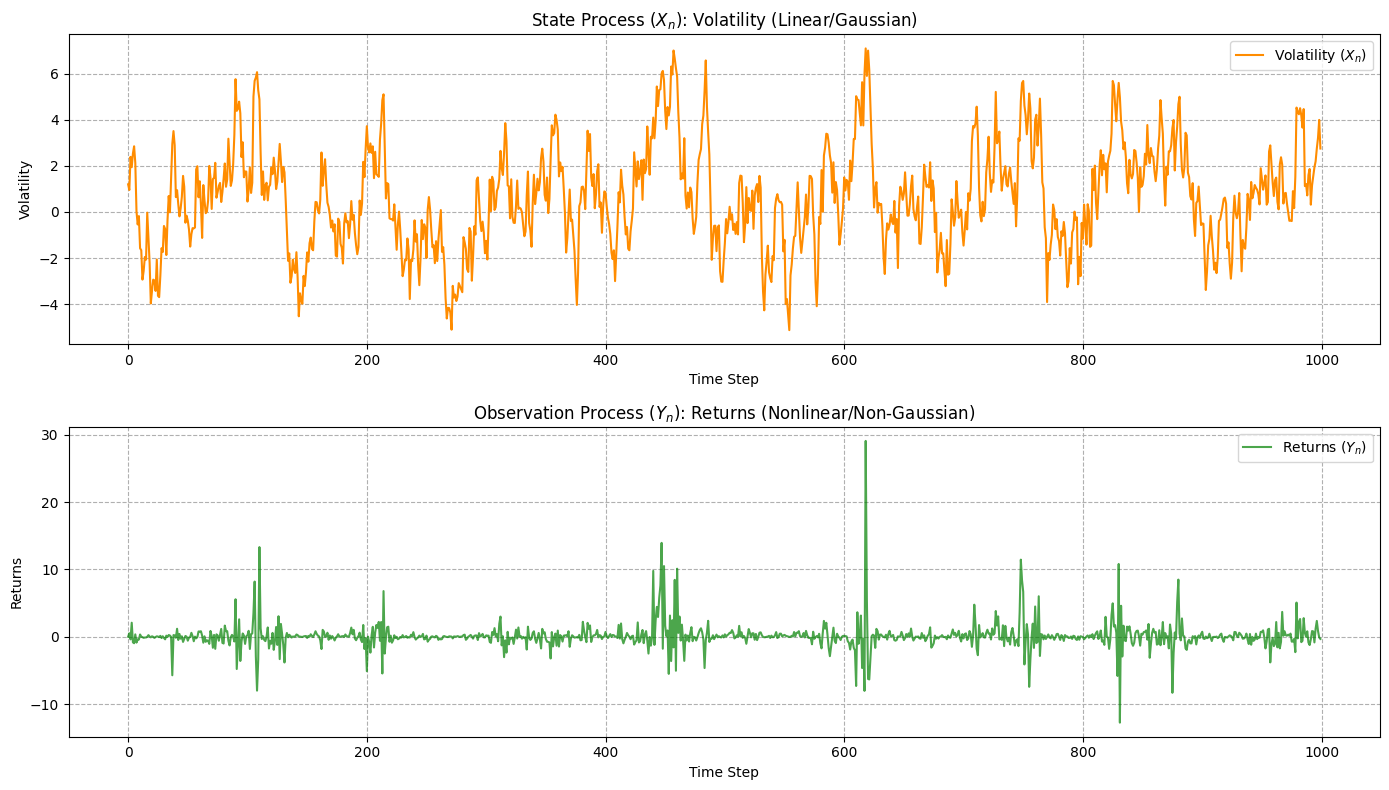

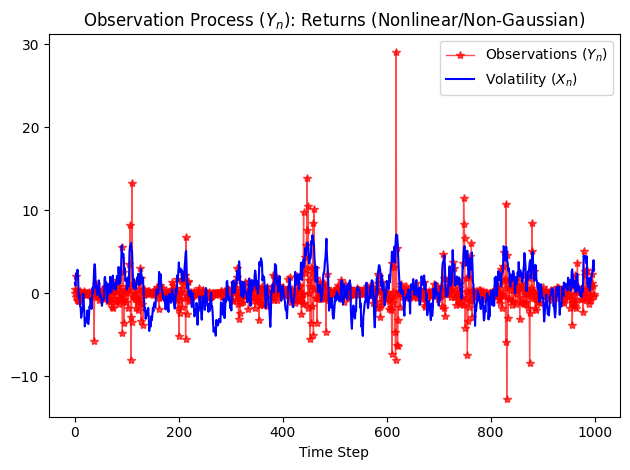

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# --- 0. Setup and Parameters ---
alpha = 0.91 # Persistence of volatility (State Model)
sigma = 1.0  # State process noise standard deviation
beta = 0.5   # Scaling factor for returns
N_steps = 1000

# Gaussian Approximation for Transformed Noise (nu = ln(beta^2) + ln(W^2))
# W ~ N(0, 1) -> ln(W^2) follows a scaled Chi-squared distribution.
mu_nu = -1.2704 # Mean of ln(W^2)
sigma_sq_nu = 4.9348 # Variance of ln(W^2)

# Initial State Distribution (for X_1)
sigma_sq_stationary = sigma**2 / (1 - alpha**2)
X1_mean = 0.0
P_init = sigma_sq_stationary

# Define Model Parameters for EKF/UKF
A_matrix = alpha # State matrix (scalar)
Q_cov = sigma**2 # Process noise covariance (scalar)
C_matrix = 1.0 # Transformed Observation Matrix: Z_n = 1.0 * X_n + nu
R_cov = sigma_sq_nu # Transformed Measurement noise variance
b_nu = mu_nu + np.log(beta**2) # Transformed Measurement noise mean (bias)

# --- 1. Simulate Data (Original SV model) ---
np.random.seed(42)
X_true = np.zeros(N_steps)
Y_obs = np.zeros(N_steps)

X_true[0] = np.random.normal(loc=X1_mean, scale=np.sqrt(P_init))

for n in range(1, N_steps):
    V_n = np.random.normal(0, 1)
    W_n = np.random.normal(0, 1)

    # State: X_n = alpha * X_{n-1} + sigma * V_n
    X_true[n] = alpha * X_true[n-1] + sigma * V_n

    # Observation: Y_n = beta * exp(X_n/2) * W_n
    Y_obs[n] = beta * np.exp(X_true[n] / 2) * W_n


# --- 2. Visualization of State and Observation ---

plt.figure(figsize=(14, 8))

# --- Top Plot: Log Volatility (State) ---
plt.subplot(2, 1, 1)
plt.plot(X_true, label='Volatility ($X_n$)', color='darkorange')
plt.title('State Process ($X_n$): Volatility (Linear/Gaussian)')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.grid(True, linestyle='--')
plt.legend()

# --- Bottom Plot: Log Returns (Observation) ---
plt.subplot(2, 1, 2)
plt.plot(Y_obs, label='Returns ($Y_n$)', color='green', alpha=0.7)
plt.title('Observation Process ($Y_n$): Returns (Nonlinear/Non-Gaussian)')
plt.xlabel('Time Step')
plt.ylabel('Returns')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(Y_obs, label='Observations ($Y_n$)', color='r', alpha=0.7, marker='*',linewidth=1)
plt.plot(X_true, label='Volatility ($X_n$)', color='b')
plt.title('Observation Process ($Y_n$): Returns (Nonlinear/Non-Gaussian)')
plt.xlabel('Time Step')
# plt.ylabel('Log Returns')
# plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


# Transformed Observation Z_n = ln(Y_n^2) for EKF/UKF
# Add a tiny epsilon to avoid ln(0) if Y_obs is exactly zero
Z_obs = np.log(Y_obs**2 + 1e-12)

In [145]:
## 2. Extended Kalman Filter (EKF) Implementation

def run_EKF(Z_obs, X_init, P_init):
    X_est = np.zeros_like(Z_obs)
    P_est = np.zeros_like(Z_obs)

    X_est[0] = X_init
    P_est[0] = P_init

    for n in range(1, N_steps):
        # 1. Prediction (Linear)
        X_pred = A_matrix * X_est[n-1]
        P_pred = A_matrix**2 * P_est[n-1] + Q_cov

        # 2. Update (Linearized)
        H = C_matrix # Jacobian is just C_matrix = 1.0

        # Innovation Covariance (S)
        S = H * P_pred * H + R_cov

        # Kalman Gain (K)
        K = P_pred * H / S

        # Update State (adjust for bias b_nu)
        innovation = Z_obs[n] - (H * X_pred + b_nu)
        X_est[n] = X_pred + K * innovation

        # Update Covariance
        P_est[n] = (1 - K * H) * P_pred

    return X_est

In [146]:
## 3. Unscented Kalman Filter (UKF) Implementation

def run_UKF(Z_obs, X_init, P_init):
    X_est = np.zeros_like(Z_obs)
    P_est = np.zeros_like(Z_obs)

    X_est[0] = X_init
    P_est[0] = P_init

    # UKF Scaling Parameters (standard choice for 1D)
    nx = 1
    alpha_ukf = 1.0 # spread of sigma points
    beta_ukf = 0.0 # higher-order term compensation
    kappa_ukf = 0.0 # secondary scaling parameter
    lambda_ukf = alpha_ukf**2 * (nx + kappa_ukf) - nx

    # Weights
    W_m = np.array([lambda_ukf / (nx + lambda_ukf), 0.5 / (nx + lambda_ukf), 0.5 / (nx + lambda_ukf)])
    W_c = np.array([lambda_ukf / (nx + lambda_ukf) + (1 - alpha_ukf**2 + beta_ukf), 0.5 / (nx + lambda_ukf), 0.5 / (nx + lambda_ukf)])

    for n in range(1, N_steps):
        X_prev = X_est[n-1]
        P_prev = P_est[n-1]

        # 1. Generate Sigma Points
        gamma = np.sqrt(nx + lambda_ukf)
        # Note: Since P_prev is a scalar, np.sqrt(P_prev) is used
        Sigma = np.array([X_prev, X_prev + gamma * np.sqrt(P_prev), X_prev - gamma * np.sqrt(P_prev)])

        # 2. Prediction (Time Update)
        X_star = A_matrix * Sigma # f(Sigma)
        X_pred = np.sum(W_m * X_star) # Predicted Mean
        P_pred = Q_cov + np.sum(W_c * (X_star - X_pred)**2) # Predicted Covariance

        # 3. Update (Measurement Update)
        Y_star = C_matrix * Sigma + b_nu # h(Sigma)
        Y_pred = np.sum(W_m * Y_star) # Predicted Observation Mean

        # Innovation Covariance (S)
        S = R_cov + np.sum(W_c * (Y_star - Y_pred)**2)

        # Cross-Covariance (Pxy)
        Pxy = np.sum(W_c * (X_star - X_pred) * (Y_star - Y_pred))

        # Kalman Gain (K)
        K = Pxy / S

        # Update State and Covariance
        innovation = Z_obs[n] - Y_pred
        X_est[n] = X_pred + K * innovation
        P_est[n] = P_pred - K**2 * S

    return X_est


--- Root Mean Square Error (RMSE) ---
RMSE (EKF): 1.2911
RMSE (UKF): 1.2995


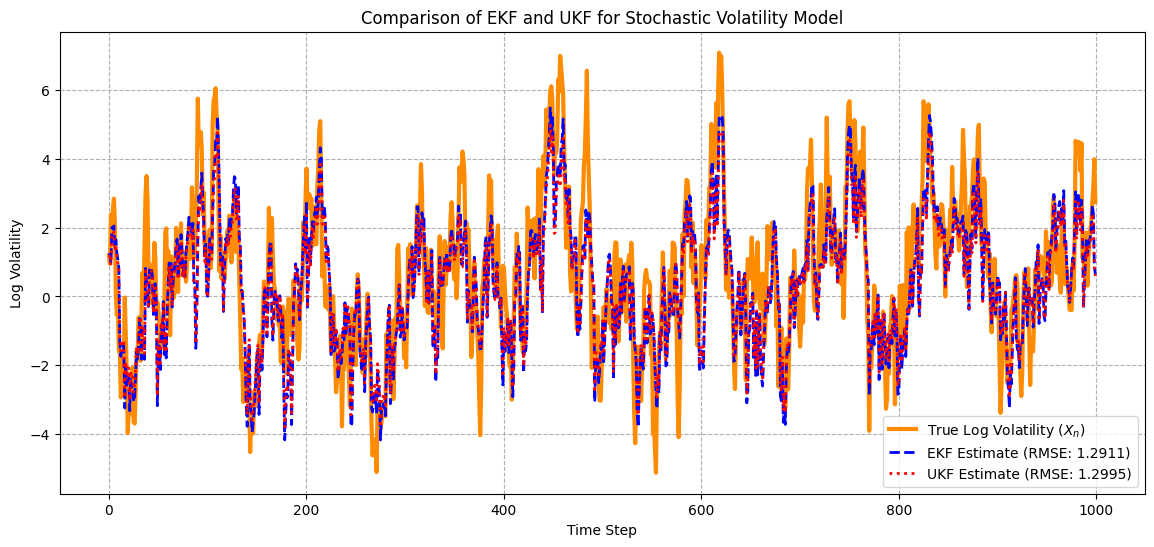

In [147]:
## 4. Comparison and Results

# Run Filters
X_est_EKF = run_EKF(Z_obs, X_true[0], P_init)
X_est_UKF = run_UKF(Z_obs, X_true[0], P_init)

# --- Quantitative Comparison (RMSE) ---
def rmse(predictions, targets):
    # Ignoring the first 10 steps for warm-up
    return np.sqrt(np.mean((predictions[10:] - targets[10:])**2))

rmse_ekf = rmse(X_est_EKF, X_true)
rmse_ukf = rmse(X_est_UKF, X_true)

print("\n--- Root Mean Square Error (RMSE) ---")
print(f"RMSE (EKF): {rmse_ekf:.4f}")
print(f"RMSE (UKF): {rmse_ukf:.4f}")


# --- Visualization ---
plt.figure(figsize=(14, 6))
plt.plot(X_true, label='True Log Volatility ($X_n$)', color='darkorange', linewidth=3)
plt.plot(X_est_EKF, label=f'EKF Estimate (RMSE: {rmse_ekf:.4f})', color='blue', linestyle='--', linewidth=2)
plt.plot(X_est_UKF, label=f'UKF Estimate (RMSE: {rmse_ukf:.4f})', color='red', linestyle=':', linewidth=2)

plt.title('Comparison of EKF and UKF for Stochastic Volatility Model')
plt.xlabel('Time Step')
plt.ylabel('Log Volatility')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

### c)	Implement a standard particle filter for your model. (Do not use the tfp.experimental.mcmc.particle_filter). Visualize and discuss issues such as particle degeneracy.

Particle Filtering Complete (with Resampling).


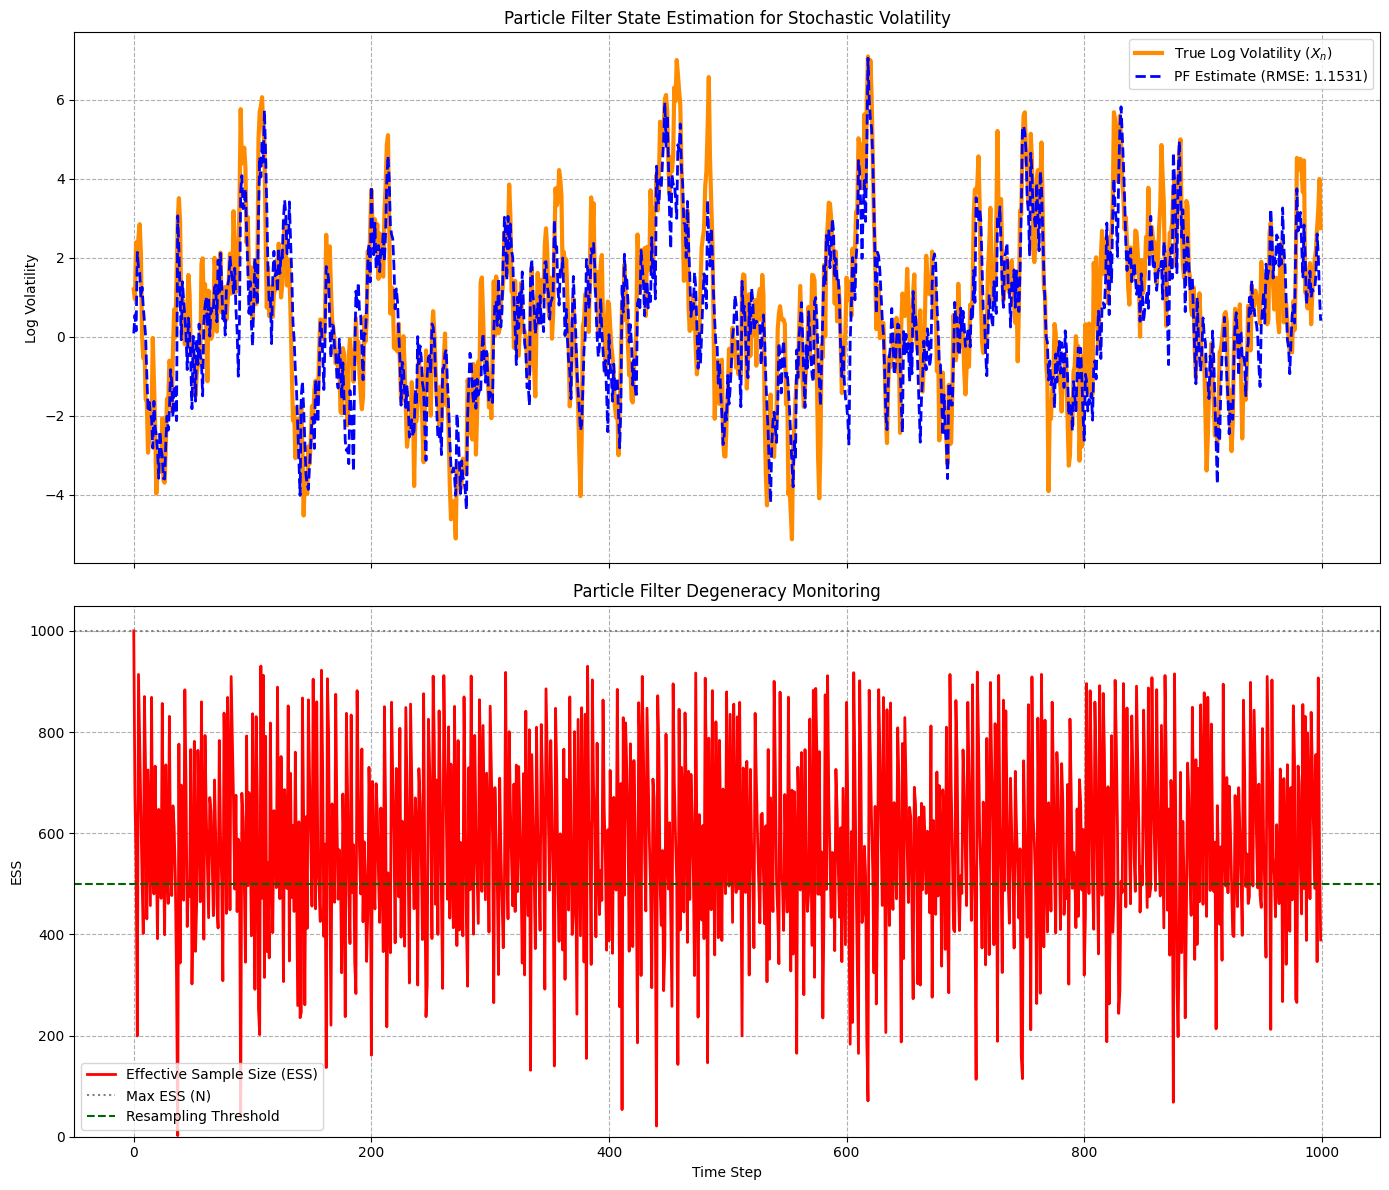


--- Particle Filter Analysis ---
Number of Particles (N): 1000
RMSE (PF Estimate): 1.1531
Average ESS: 577.55


In [152]:
import numpy as np
import matplotlib.pyplot as plt

# # --- 0. Setup and Parameters ---
# alpha = 0.91 # Persistence of volatility
# sigma = 1.0  # State process noise standard deviation
# beta = 0.5   # Scaling factor for returns
# N_steps = 1000
N_particles = 1000 # Number of particles

# # Initial State Distribution
# sigma_sq_stationary = sigma**2 / (1 - alpha**2)
# P_init = sigma_sq_stationary
# X1_mean = 0.0

# Function to calculate Effective Sample Size (ESS)
def calculate_ESS(weights):
    """ESS = 1 / sum(weights^2)"""
    # Sum of squares of normalized weights
    return 1.0 / np.sum(weights**2)

# # --- 1. Simulate Data (Original SV model) ---
# np.random.seed(42)
# X_true = np.zeros(N_steps)
# Y_obs = np.zeros(N_steps)

# # Sample X_1 from the stationary distribution
# X_true[0] = np.random.normal(loc=X1_mean, scale=np.sqrt(P_init))

# for n in range(1, N_steps):
#     V_n = np.random.normal(0, 1) # Process Noise
#     W_n = np.random.normal(0, 1) # Measurement Noise

#     # State: X_n = alpha * X_{n-1} + sigma * V_n
#     X_true[n] = alpha * X_true[n-1] + sigma * V_n

#     # Observation: Y_n = beta * exp(X_n/2) * W_n
#     Y_obs[n] = beta * np.exp(X_true[n] / 2) * W_n

# print("Stochastic Volatility Data Simulation Complete.")

# --- 2. Particle Filter Implementation ---

# Initialize arrays
X_particles = np.zeros((N_particles, N_steps))
W_weights = np.ones((N_particles, N_steps)) / N_particles # Initial uniform weights
X_est = np.zeros(N_steps) # Final estimate (weighted mean)
ESS_history = np.zeros(N_steps)

# Initial state: Sample X_1 particles
X_particles[:, 0] = np.random.normal(loc=X1_mean, scale=np.sqrt(P_init), size=N_particles)
X_est[0] = np.mean(X_particles[:, 0])
ESS_history[0] = N_particles

sigma_proc = sigma # Process Noise Standard Deviation

for n in range(1, N_steps):
    X_prev = X_particles[:, n-1]

    # --- Step 1: Prediction (Propagation) ---
    # Sample new particles X_n from the transition density p(X_n | X_{n-1})
    V_n = np.random.normal(0, 1, N_particles)
    X_pred = alpha * X_prev + sigma_proc * V_n

    # --- Step 2: Weighting (Likelihood) ---
    Y_n = Y_obs[n]

    # Calculate the conditional variance for each predicted particle
    # Var(Y_n | X_n) = beta^2 * exp(X_n)
    obs_variance = beta**2 * np.exp(X_pred)

    # Calculate log likelihood using the Gaussian PDF: log(p(Y_n | X_n))
    log_likelihoods = -0.5 * np.log(2 * np.pi * obs_variance) - 0.5 * (Y_n**2 / obs_variance)

    # Calculate unnormalized weights: w_n = w_{n-1} * p(Y_n | X_n)
    # Using previous normalized weight w_{n-1} (W_weights[:, n-1])
    unnormalized_weights = W_weights[:, n-1] * np.exp(log_likelihoods)

    # Normalize weights
    sum_unnorm = np.sum(unnormalized_weights)
    if sum_unnorm > 0:
        W_weights[:, n] = unnormalized_weights / sum_unnorm
    else:
        # Avoid collapse: reset weights if the sum is zero
        W_weights[:, n] = 1.0 / N_particles

    # --- Step 3: Estimate and Storage ---
    # Current estimate is the weighted mean of the predicted particles
    # FIX APPLIED: Using X_pred (predicted particles)
    X_est[n] = np.sum(X_pred * W_weights[:, n])

    # Store the predicted particles (which are about to be resampled)
    X_particles[:, n] = X_pred

    # --- Step 4: Resampling Check ---
    ESS = calculate_ESS(W_weights[:, n])
    ESS_history[n] = ESS

    # Resample if ESS falls below the threshold (e.g., N_particles / 2)
    if ESS < N_particles / 2:
        # Create cumulative sum of weights
        cum_weights = np.cumsum(W_weights[:, n])

        # Draw N_particles from a uniform distribution (U[0,1])
        rand_draws = np.random.rand(N_particles)

        # Find indices (Inverse Transform Sampling)
        indices = np.searchsorted(cum_weights, rand_draws)

        # Resample particles and reset weights
        X_particles[:, n] = X_particles[indices, n]
        W_weights[:, n] = 1.0 / N_particles # Reset weights to uniform

        # Note: No need to update X_est again, as the estimate was calculated before resampling.

print("Particle Filtering Complete (with Resampling).")

# --- 3. Visualization and Degeneracy Analysis ---

# Calculate RMSE for quantitative comparison
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions[10:] - targets[10:])**2))

rmse_pf = rmse(X_est, X_true)

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 1. State Estimation (Tracking)
axs[0].plot(X_true, label='True Log Volatility ($X_n$)', color='darkorange', linewidth=3)
axs[0].plot(X_est, label=f'PF Estimate (RMSE: {rmse_pf:.4f})', color='blue', linestyle='--', linewidth=2)
axs[0].set_title('Particle Filter State Estimation for Stochastic Volatility')
axs[0].set_ylabel('Log Volatility')
axs[0].legend()
axs[0].grid(True, linestyle='--')

# # 2. Observation Process (For Context)
# axs[1].plot(Y_obs, label='Log Returns ($Y_n$)', color='green', alpha=0.7)
# axs[1].set_title('Log Returns (Observation)')
# axs[1].set_ylabel('Returns')
# axs[1].grid(True, linestyle='--')
# axs[1].legend()

# 3. Particle Degeneracy (ESS)
# Discusses issues such as particle degeneracy
axs[1].plot(ESS_history, label='Effective Sample Size (ESS)', color='red', linewidth=2)
axs[1].axhline(N_particles, color='gray', linestyle=':', label='Max ESS (N)')
axs[1].axhline(N_particles / 2, color='darkgreen', linestyle='--', label='Resampling Threshold')
axs[1].set_title('Particle Filter Degeneracy Monitoring')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('ESS')
axs[1].set_ylim(0, N_particles * 1.05)
axs[1].legend()
axs[1].grid(True, linestyle='--')

plt.tight_layout()
plt.show()

print("\n--- Particle Filter Analysis ---")
print(f"Number of Particles (N): {N_particles}")
print(f"RMSE (PF Estimate): {rmse_pf:.4f}")
print(f"Average ESS: {np.mean(ESS_history):.2f}")